In [ ]:
!curl -L -o ./oriental-rug-images.zip https://www.kaggle.com/api/v1/datasets/download/kianeliasi/oriental-rug-images
!mkdir rugs_in
!unzip ./oriental-rug-images.zip -d rugs_in

In [2]:
from huggingface_hub import login

login()

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from accelerate import Accelerator
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from peft import LoraConfig, get_peft_model
import numpy as np


DATA_ROOT = "rugs_in"
OUT_DIR = "rugs_out"
RESOLUTION = 1024
BATCH_SIZE = 1
MAX_TRAIN_STEPS = 1200
LR = 1e-5
SEED = 42
MODEL_ID = "stable-diffusion-v1-5/stable-diffusion-v1-5"
INSTANCE_PROMPT = "photo of a rug"

os.makedirs(OUT_DIR, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Load Dataset

In [4]:
class RugDataset(Dataset):
    def __init__(self, root_dir, resolution=1024):
        self.paths = []
        for root, _, files in os.walk(root_dir):
            for f in files:
                if f.lower().endswith((".jpg")):
                    self.paths.append(os.path.join(root, f))
        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]) # -> [-1,1]
        ])
        if len(self.paths) == 0:
            raise ValueError(f"No images found in {root_dir}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        img = self.transform(img)  # C,H,W in [-1,1]
        return {"pixel_values": img, "path": p}

# build dataset + dataloader
dataset = RugDataset(DATA_ROOT, RESOLUTION)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataset size:", len(dataset))

Dataset size: 1000


## Setup Base Model

In [ ]:
vae = AutoencoderKL.from_pretrained(MODEL_ID, subfolder="vae").to(device)
vae.requires_grad_(False)

tokenizer = CLIPTokenizer.from_pretrained(MODEL_ID, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(MODEL_ID, subfolder="text_encoder").to(device)
text_encoder.requires_grad_(False)

unet = UNet2DConditionModel.from_pretrained(MODEL_ID, subfolder="unet").to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=MAX_TRAIN_STEPS)

lora_r = 8
lora_alpha = 16
lora_dropout = 0.05

lora_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    target_modules=["to_q", "to_k", "to_v", "proj_in", "proj_out"],
    lora_dropout=lora_dropout,
    bias="none"
)

print("Wrapping UNet with LoRA adapters (PEFT)...")
unet = get_peft_model(unet, lora_config)

trainable_params = 0
for n, p in unet.named_parameters():
    if p.requires_grad:
        trainable_params += p.numel()
print(f"Trainable params (LoRA): {trainable_params:,}")

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Wrapping UNet with LoRA adapters (PEFT)...
Trainable params (LoRA): 1,594,368


In [6]:
accelerator = Accelerator(mixed_precision="fp16" if torch.cuda.is_available() else "no")
unet.train()

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, unet.parameters()), lr=LR)

unet, optimizer, dataloader = accelerator.prepare(unet, optimizer, dataloader)

def get_text_embeddings(prompt):
    inputs = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    with torch.no_grad():
        embeddings = text_encoder(input_ids)[0]
    return embeddings

text_embeddings = get_text_embeddings(INSTANCE_PROMPT)

## Training Loop

In [8]:
import random
import torch.nn.functional as F
from tqdm.auto import tqdm


global_step = 0
total_steps = MAX_TRAIN_STEPS

pbar = tqdm(range(total_steps), desc="Train LoRA")
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

for step in pbar:
    try:
        batch = next(dataloader_iter)
    except:
        dataloader_iter = iter(dataloader)
        batch = next(dataloader_iter)

    pixel_values = batch["pixel_values"].to(accelerator.device, non_blocking=True)  # (B, C, H, W)
    b = pixel_values.shape[0]

    # 1) Encode images into latents with VAE (no grad)
    with torch.no_grad():
        latents = vae.encode((pixel_values + 1) / 2).latent_dist.sample()  # VAE expects [0,1]
        latents = latents * 0.18215  # scaling factor used in SD

    # 2) Sample random noise and timesteps
    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (b,), device=latents.device).long()

    # 3) Add noise
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    # 4) expand text embeddings to batch
    encoder_hidden_states = text_embeddings.expand(b, -1, -1).to(accelerator.device)

    # 5) predict the noise residual with UNet (LoRA-enabled)
    model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=encoder_hidden_states).sample

    # 6) compute MSE loss with the noise
    loss = F.mse_loss(model_pred, noise)

    optimizer.zero_grad()
    accelerator.backward(loss)
    optimizer.step()

    global_step += 1
    if global_step % 10 == 0:
        pbar.set_postfix({'loss': float(loss.detach().item()), 'step': global_step})

    # Save LoRA adapters periodically
    if global_step % 400 == 0 or global_step == total_steps:
        accelerator.wait_for_everyone()
        # unwrap to CPU and save the peft adapter weights (LoRA)
        unwrapped = accelerator.unwrap_model(unet)
        save_dir = os.path.join(OUT_DIR, f"lora-step{global_step:04}")
        os.makedirs(save_dir, exist_ok=True)
        # Peft provides save_pretrained on the model
        unwrapped.save_pretrained(save_dir)
        if accelerator.is_main_process:
            print(f"Saved LoRA adapters to {save_dir}")

    if global_step >= total_steps:
        break

print("Training completed. Final adapters are in", OUT_DIR)

Train LoRA:   0%|          | 0/1200 [00:00<?, ?it/s]

Saved LoRA adapters to rugs_out/lora-step0400
Saved LoRA adapters to rugs_out/lora-step0800
Saved LoRA adapters to rugs_out/lora-step1200
Training completed. Final adapters are in rugs_out


## Generate a Sample

In [9]:
from diffusers import StableDiffusionPipeline
from peft import PeftModel

pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float16).to(device)

adapter_folder = sorted([os.path.join(OUT_DIR, d) for d in os.listdir(OUT_DIR)], reverse=True)[0]
print("Loading LoRA adapter from", adapter_folder)
# To use PEFT adapters with a UNet object, we load peft weights into unet: some integrations allow load via pipe.unet.load_attn_procs(...)
# If you saved using unet.save_pretrained (peft), you can load via get_peft_model + set_pretrained... but easiest approach:
from peft import PeftModel
# Wrap the pipeline's UNet to peft model and load
pipe.unet = PeftModel.from_pretrained(pipe.unet, adapter_folder).to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading LoRA adapter from rugs_out/lora-step1200


  0%|          | 0/30 [00:00<?, ?it/s]

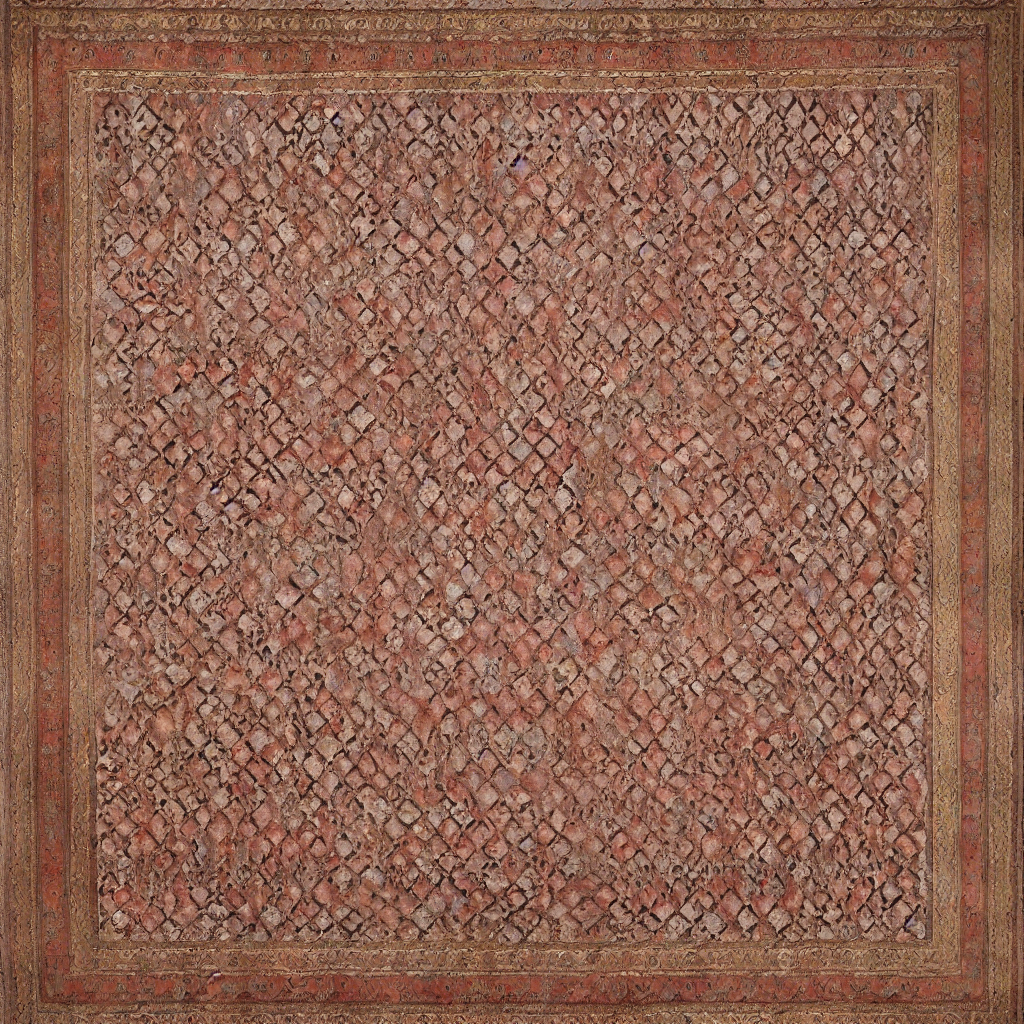

In [25]:
prompt = "photo of a rug"
image = pipe(prompt, height=RESOLUTION, width=RESOLUTION, num_inference_steps=30, guidance_scale=7.5).images[0]
display(image)

## Save the Model and Upload to Hub

In [35]:
merged_model_path = "./rugs-sd15-merged"
pipe.unet = pipe.unet.merge_and_unload()
pipe.save_pretrained(merged_model_path, safe_serialization=True)

In [36]:
from huggingface_hub import create_repo, upload_folder

repo_id = "kianelbo/magic-rugs-sd15"
create_repo(repo_id, private=True)
upload_folder(
    repo_id=repo_id,
    folder_path=merged_model_path,
    commit_message="Upload merged Stable Diffusion rug model"
)

model.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kianelbo/magic-rugs-sd15/commit/c7c2b9d4762cb0cb6e8fc9386c9e5e0ce57df936', commit_message='Upload merged Stable Diffusion rug model', commit_description='', oid='c7c2b9d4762cb0cb6e8fc9386c9e5e0ce57df936', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kianelbo/magic-rugs-sd15', endpoint='https://huggingface.co', repo_type='model', repo_id='kianelbo/magic-rugs-sd15'), pr_revision=None, pr_num=None)